# Clase Autoencoder con capas convolucionales - Imágenes escala de grises.

En el siguiente Notebook vamos a seguir explorando la clase Autoencoder que hicimos en el notebook anterior. En este caso, lo haremos a través de capas convolucionales en lugar de densas. Es mucho más apropiado usar capas convolucionales porque el objetivo del AutoEncoder es, por una parte, realizar una buena extracción de características de las imágenes y, por otro, realizar una buena reconstrrucción de dichas caracterísitcas para poder rescatar una aproximación de la imágen original. Por ese motivo, las convolucionales serán mucho más efectivas.

In [2]:
#Librerías necesarias

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import plotly.express as px
from IPython.display import clear_output
tf.random.set_seed(666)

## Clase AutoEncoder con capas convolucionales.

Modificaremos la clase anterior para que las capas sean convolucionales. Además de contar con las capas Conv2D, también habremos de incorporar las capas de MaxPooling y las Conv2DTranspose, que son las que participan en el decoder como operación inversa de las Conv2D.

La estructura es:
- Encoder:
    - Conv2D en las que hay que especificar el ```paddign = "same"```. 32 filtros en todas las capas de este tipo.
    - MaxPooling de (2,2) para que la imagen vaya reduciendo su tamaño (cada vez a la mitad del anterior).
    - Capa Flatten para preparar la imagen final para el espacio latente.
    - Capa densa de tamaño 2 que representa el espacio latente. 

- Decoder:
    - Capa densa con el mismo tamaño que la Flatten anterior para recuperar el tamaño de la imagen pequeña (en este caso 7*7).
    - Conv2DTranspose que hace la operación inversa de las Conv2D. Hay que especificar el ```strides``` para duplicar el tamaño de la imagen en cada paso y recuperar el tamaño 28*28.

In [23]:
class AutoEncoder_conv(tf.keras.Model):
    """
    AutoEncoder con capas convolucionales.
    """
    def __init__(self, input_shape, latent_dim):
        """
        Parameters
        ----------
        input_shape: int
            Ancho/largo de las imágenes.
        latent_dim: int
            Dimensión del espacio latente.
        """
        super(AutoEncoder_conv, self).__init__() #Hereda todos los métodos de tf.keras.Model
        
        #Creamos el modelo secuencial para el encoder
        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), #Imagen28*28
                                   input_shape=(input_shape,input_shape,1), padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), #Reducimos la imagen a la mitad 14*14
            tf.keras.layers.Conv2D(16, (3,3), padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),#Reducimos la imagen a la mitad 7*7
            tf.keras.layers.Conv2D(8, (3,3), padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(250),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(200),#Red densa
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(50),#Red densa
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(latent_dim)#Red densa de dos nodos (espacio latente)
        ])
        
        self.decoder = tf.keras.models.Sequential([
            tf.keras.layers.Dense(50, input_shape=(latent_dim,)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(200),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(250),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dense(7*7*8),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape((7,7,8)),
            tf.keras.layers.Conv2DTranspose(16,(3,3), padding='same', strides = (2,2)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(32,(3,3), padding='same', strides = (2,2)),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2DTranspose(1,(3,3), padding='same', strides = (1,1)),
            tf.keras.layers.LeakyReLU()
        ])
    
    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded    

In [11]:
def reconstruccion(n, data):

  encoded_imgs = ae_conv.encoder(data[:n]).numpy()
  decoded_imgs = ae_conv.decoder(encoded_imgs).numpy()


  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data[i].reshape(28,28))
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.title("Reconstruida")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [4]:
class CallBackReconstruccion(tf.keras.callbacks.Callback):

    def __init__(self, n, data):
        """
        Parameters
        ----------
        n: int
            Número de imágenes a reconstruir.
        data: list
            Listado original de imágenes.
        """
        self.n = n
        self.data = data

    def on_epoch_end(self, epoch, logs=None):
        reconstruccion(self.n, self.data)


## Datos MNIST

Vamos a volver a usar el conjunto de datos MNIST por su sencillez. Será sufieciente para probar nuestra nueva clases con las nuevas capas. En este caso, no visualizaremos las imágenes de muestra.

Cargamos los datos de MNIST

In [5]:
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.mnist.load_data()
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Normalizamos para que en lugar de tener un rango de [0,255] lo tenga de [0,1].

In [6]:
Xtrain = Xtrain / 255
Xtest = Xtest / 255

Es importante expandir las dimensiones de las imágenes para que se explicite el número de canales con las que cuenta la imagen y poder pasarlas por la Conv2D.

In [7]:
Xtrain = np.expand_dims(Xtrain,-1)
Xtest = np.expand_dims(Xtest,-1)

In [24]:
ae_conv = AutoEncoder_conv(input_shape=Xtrain.shape[1], latent_dim=2)

In [25]:
#Seleccionamos el optimizador y la función de pérdida
ae_conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss = "mean_squared_error")

Epoch 1/20
938/938 [==============================] - 15s 15ms/step - loss: 0.0532 - val_loss: 0.0459


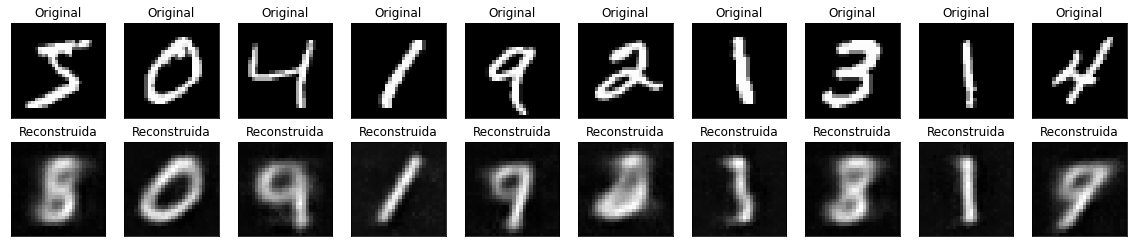

Epoch 2/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0445 - val_loss: 0.0438


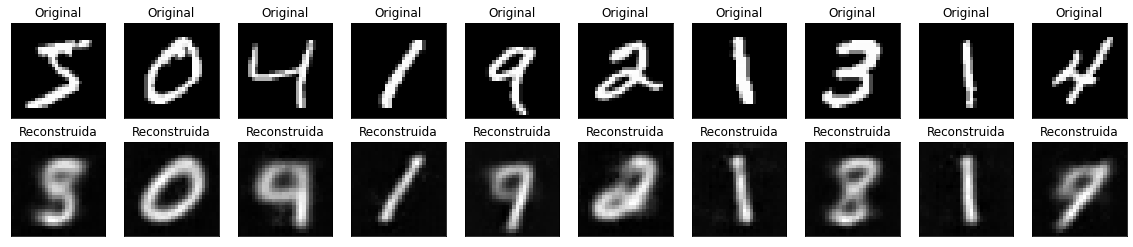

Epoch 3/20
938/938 [==============================] - 15s 16ms/step - loss: 0.0429 - val_loss: 0.0435


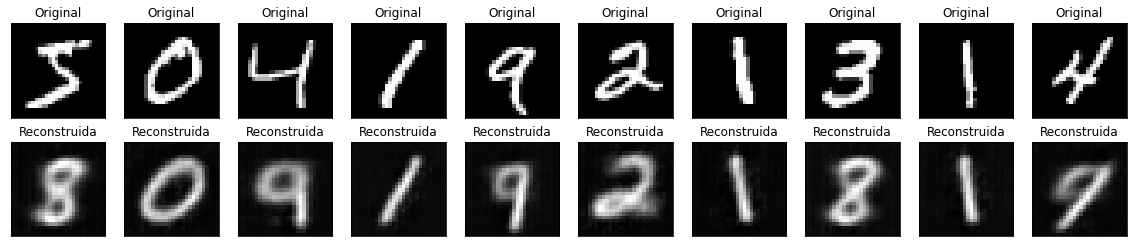

Epoch 4/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0423 - val_loss: 0.0424


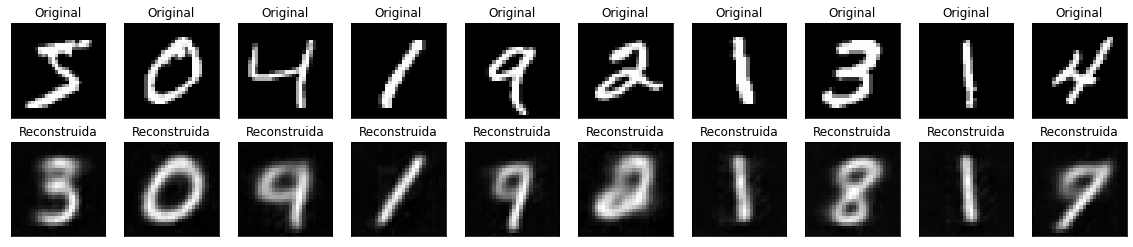

Epoch 5/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0417 - val_loss: 0.0414


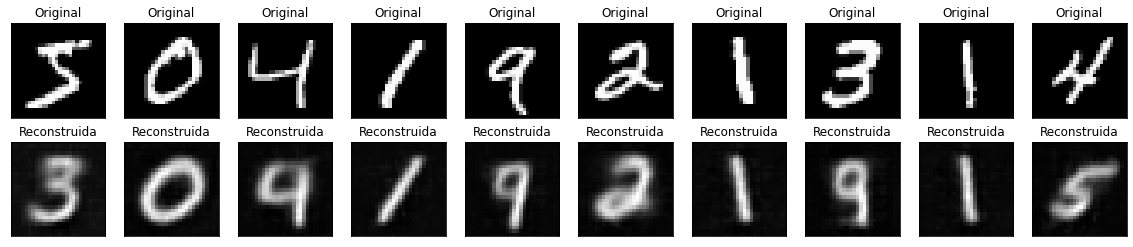

Epoch 6/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0412 - val_loss: 0.0404


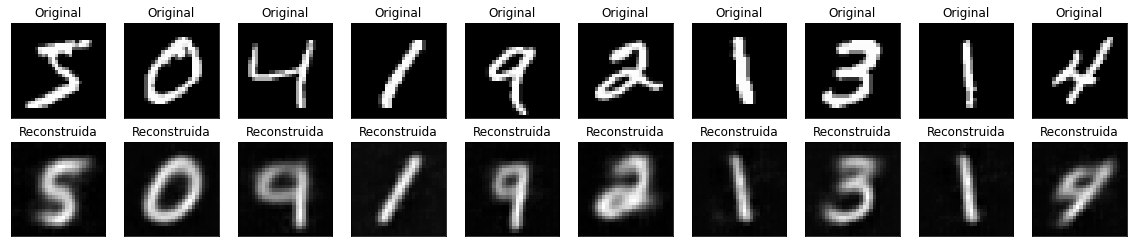

Epoch 7/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0409 - val_loss: 0.0407


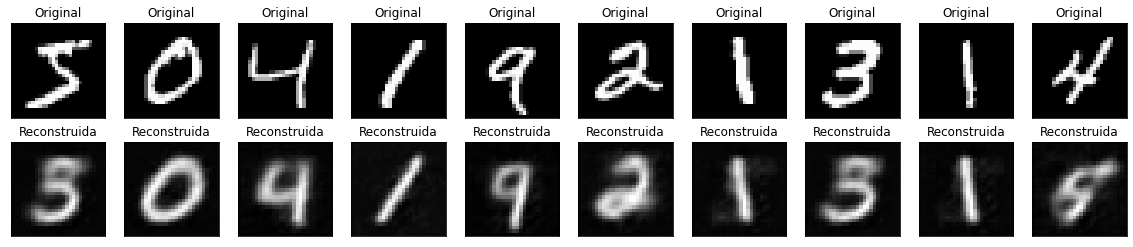

Epoch 8/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0410 - val_loss: 0.0424


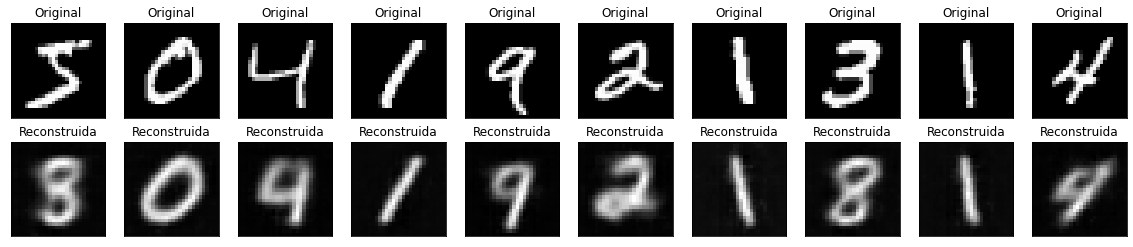

Epoch 9/20
938/938 [==============================] - 15s 16ms/step - loss: 0.0404 - val_loss: 0.0398


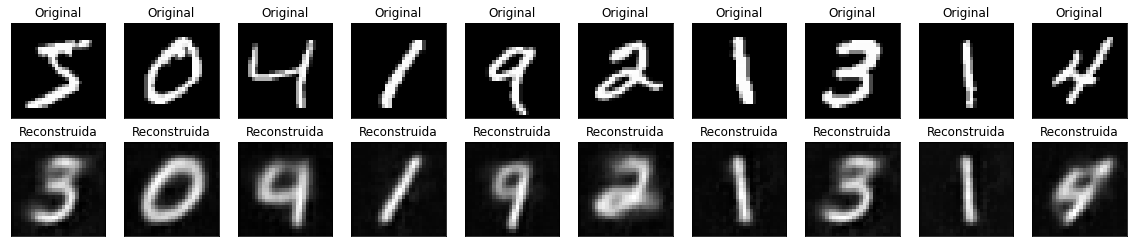

Epoch 10/20
938/938 [==============================] - 15s 16ms/step - loss: 0.0402 - val_loss: 0.0395


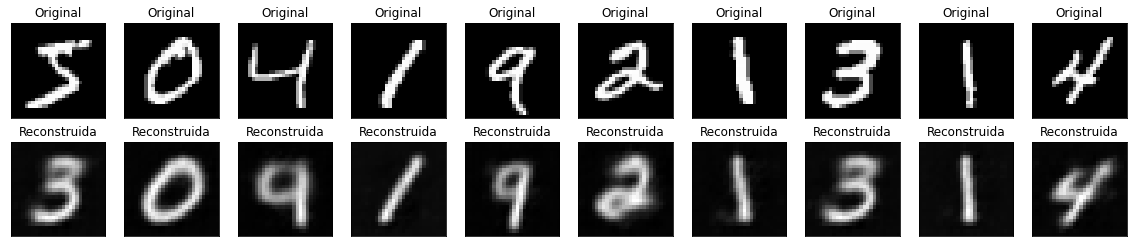

Epoch 11/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0399 - val_loss: 0.0395


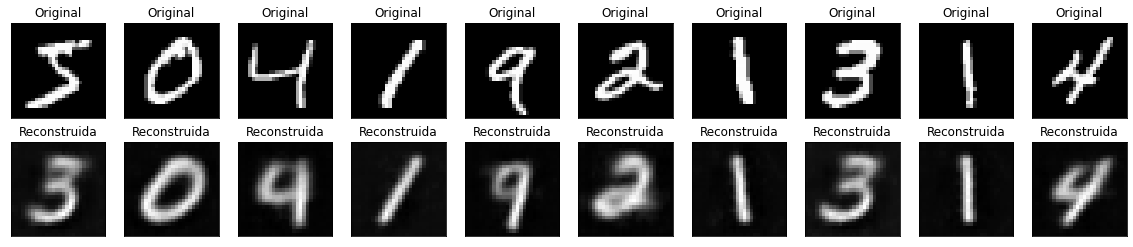

Epoch 12/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0398 - val_loss: 0.0393


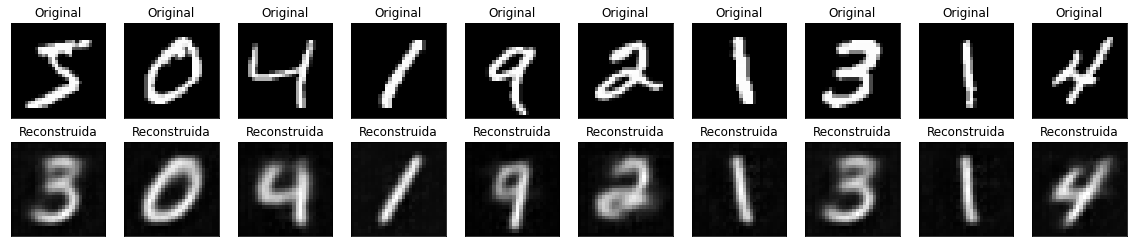

Epoch 13/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0398 - val_loss: 0.0398


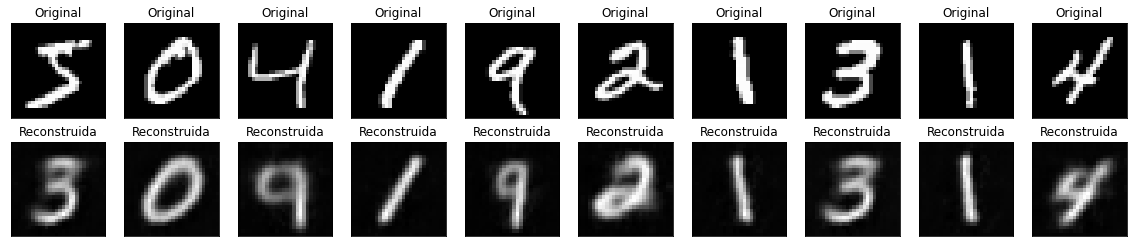

Epoch 14/20
938/938 [==============================] - 15s 15ms/step - loss: 0.0396 - val_loss: 0.0398


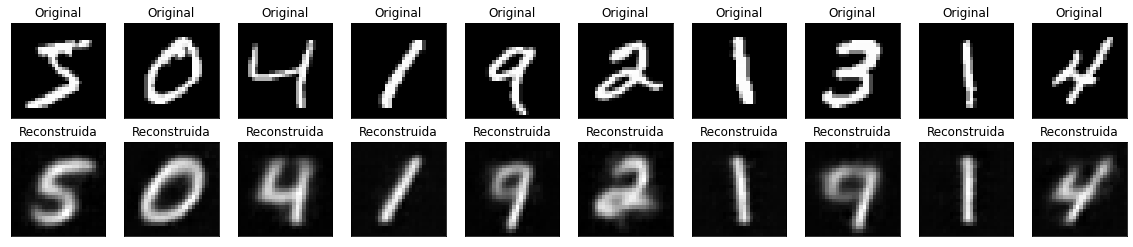

Epoch 15/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0395 - val_loss: 0.0396


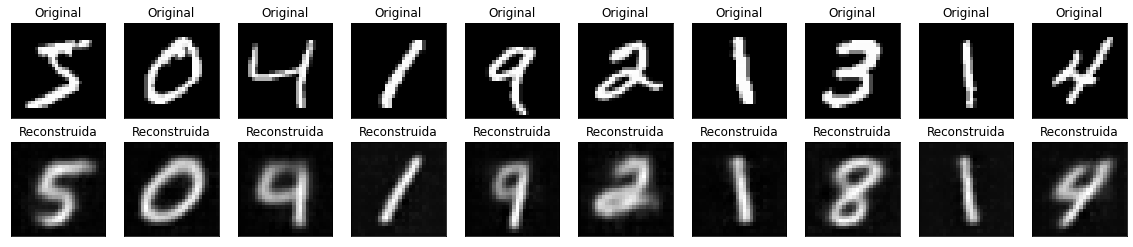

Epoch 16/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0395 - val_loss: 0.0388


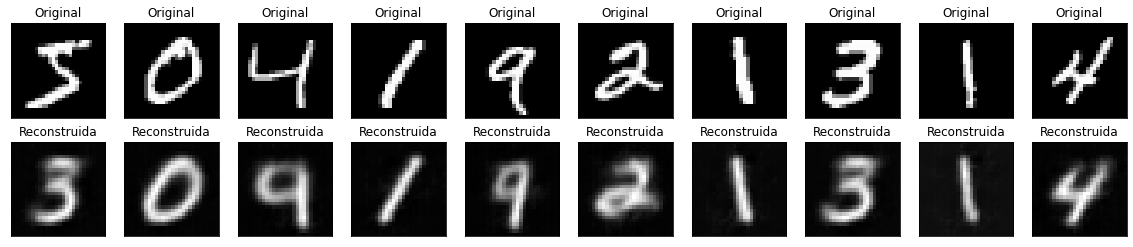

Epoch 17/20
938/938 [==============================] - 14s 14ms/step - loss: 0.0391 - val_loss: 0.0385


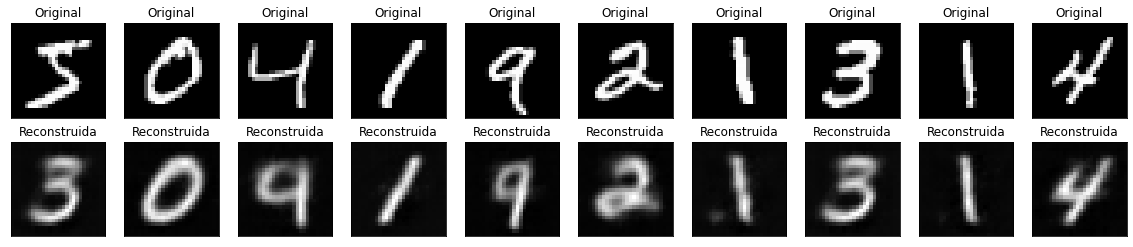

Epoch 18/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0390 - val_loss: 0.0383


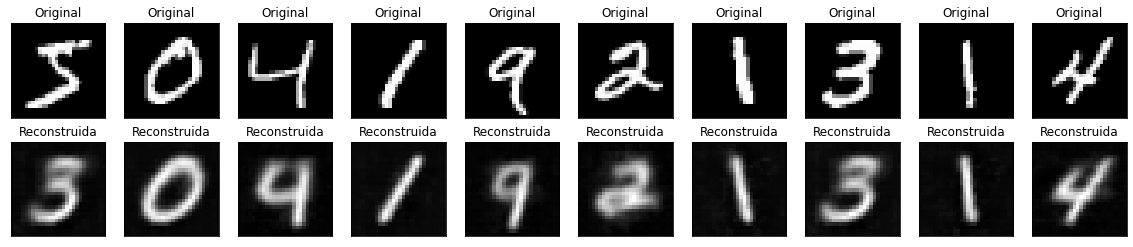

Epoch 19/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0388 - val_loss: 0.0394


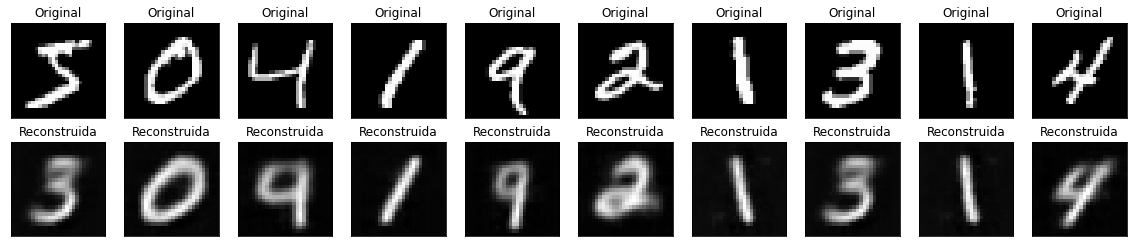

Epoch 20/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0389 - val_loss: 0.0384


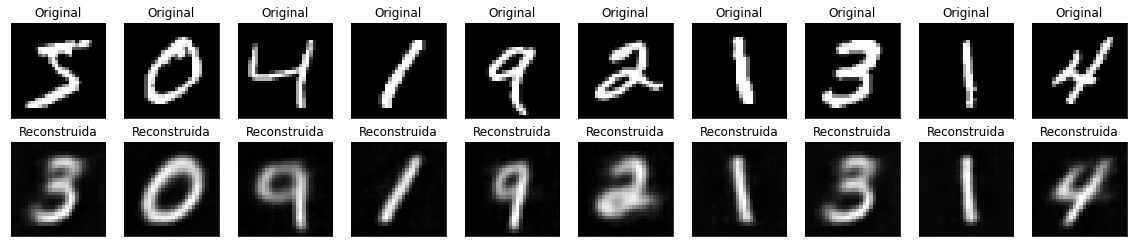

In [26]:
history = ae_conv.fit(Xtrain, Xtrain, 
                           epochs = 20,     
                           batch_size = 64, 
                           shuffle = True, 
                           validation_data=(Xtest, Xtest),
                           callbacks=[CallBackReconstruccion(n=10, data=Xtrain)])

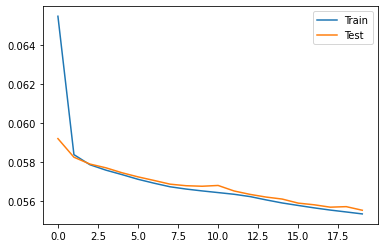

In [49]:
plt.figure()
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.legend()
plt.show()

In [22]:
#Codificamos todo los datos de train y los pintamos en función de su etiqueta
latent = ae_conv.encoder(Xtrain[1:10000])
latent_df = pd.DataFrame(latent)
latent_df["label"] = Ytrain[1:10000].astype(str)

In [23]:
px.scatter(latent_df, x = 0, y = 1, color = "label",
          category_orders={"label": ["0","1", "2", "3", "4", "5", "6", "7", "8", "9"]})

In [50]:
encoded_imgs = ae_conv.encoder(Xtest).numpy()
decoded_imgs = ae_conv.decoder(encoded_imgs).numpy()

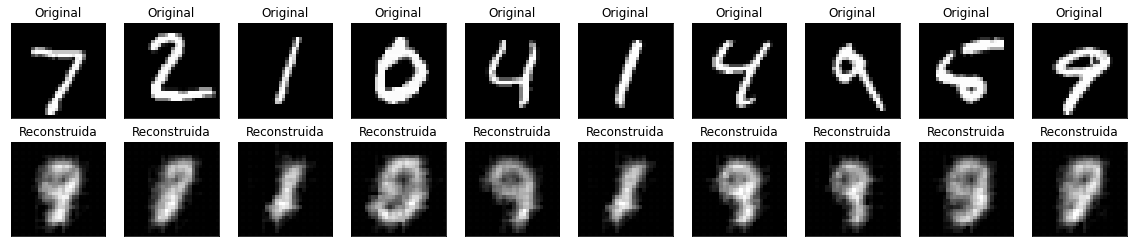

In [64]:
reconstruccion(n = 10, data = Xtest)

## Fashion-Mnist

In [26]:
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.fashion_mnist.load_data();
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Normalizamos y añadimos una nueva dimensión a las imagene spara que pasen correctamente por la Conv2D

In [27]:
Xtrain = Xtrain / 255
Xtest = Xtest / 255

In [28]:
Xtrain = np.expand_dims(Xtrain,-1)
Xtest = np.expand_dims(Xtest,-1)

In [29]:
ae_conv = AutoEncoder_conv(input_shape=Xtrain.shape[1], latent_dim=2)

In [30]:
#Seleccionamos el optimizador y la función de pérdida
ae_conv.compile(optimizer="adam", loss = "mean_squared_error")

In [31]:
history = ae_conv.fit(Xtrain, Xtrain, 
                           epochs = 20, 
                           batch_size = 64, 
                           shuffle = True, 
                           validation_data=(Xtest, Xtest))

Epoch 1/20
938/938 [==============================] - 9s 10ms/step - loss: 0.1031 - val_loss: 0.0969
Epoch 2/20
938/938 [==============================] - 10s 10ms/step - loss: 0.0642 - val_loss: 0.0553
Epoch 3/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0551 - val_loss: 0.0546
Epoch 4/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0546 - val_loss: 0.0543
Epoch 5/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0544 - val_loss: 0.0541
Epoch 6/20
938/938 [==============================] - 11s 12ms/step - loss: 0.0538 - val_loss: 0.0533
Epoch 7/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0534 - val_loss: 0.0533
Epoch 8/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0533 - val_loss: 0.0531
Epoch 9/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0532 - val_loss: 0.0531
Epoch 10/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0531 - val_

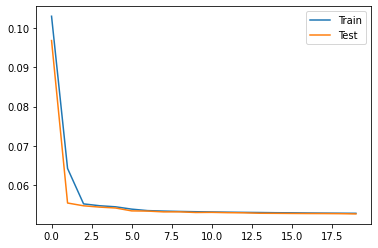

In [32]:
plt.figure()
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.legend()
plt.show()

In [33]:
#Codificamos todo los datos de train y los pintamos en función de su etiqueta
latent = ae_conv.encoder(Xtrain[1:5000])
latent_df = pd.DataFrame(latent)
latent_df["label"] = Ytrain[1:5000].astype(str)

In [34]:
px.scatter(latent_df, x = 0, y = 1, color = "label",
          category_orders={"label": ["0","1", "2", "3", "4", "5", "6", "7", "8", "9"]})

In [35]:
encoded_imgs = ae_conv.encoder(Xtest).numpy()
decoded_imgs = ae_conv.decoder(encoded_imgs).numpy()

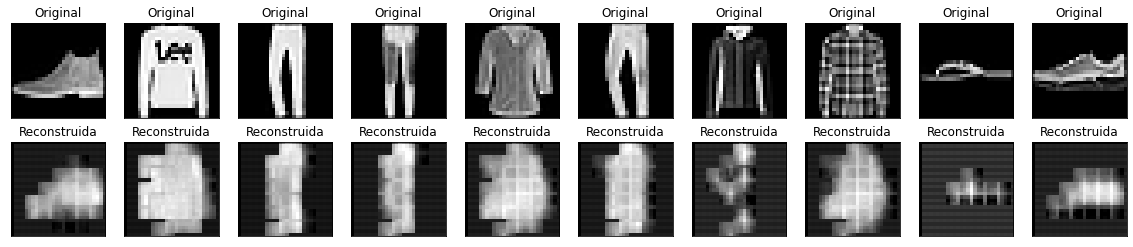

In [36]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(Xtest[i].reshape(28,28))
  plt.title("Original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.title("Reconstruida")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Pese a que la reconstrucción es buena, podríamos pensar que, tal vez, con una mayor dimensionalidad del espacio latente, podríamos llegar a una mejor reconstrucción porque nos quedaríamos con una mayor cantidad de características.

In [37]:
#Definimos un nuevo modelo con 4 dimensiones en el espacio latente.
ae_tanh = AutoEncoder_conv(input_shape=Xtrain.shape[1], latent_dim=4)
ae_tanh.compile(optimizer="adam", loss = "mean_squared_error")

In [38]:
history_tanh = ae_tanh.fit(Xtrain, Xtrain, 
                           epochs = 20, 
                           batch_size = 64, 
                           shuffle = True, 
                           validation_data=(Xtest, Xtest))

Epoch 1/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0796 - val_loss: 0.0431
Epoch 2/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0411 - val_loss: 0.0401
Epoch 3/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0397 - val_loss: 0.0393
Epoch 4/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0391 - val_loss: 0.0388
Epoch 5/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0388 - val_loss: 0.0386
Epoch 6/20
938/938 [==============================] - 10s 11ms/step - loss: 0.0384 - val_loss: 0.0383
Epoch 7/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0382 - val_loss: 0.0381
Epoch 8/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0379 - val_loss: 0.0377
Epoch 9/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0375 - val_loss: 0.0374
Epoch 10/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0373 - val_loss: 0.03

Observamos si ahora hay o no overfit. Además de no haberlo, también se puede comprobar que se comete menos error tanto en train como en test.

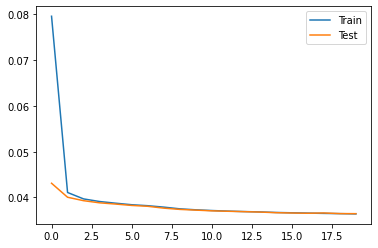

In [39]:
plt.figure()
plt.plot(history_tanh.history["loss"], label="Train")
plt.plot(history_tanh.history["val_loss"], label="Test")
plt.legend()
plt.show()

Como el espacio latente tiene 4 dimensiones no se puede visualizar, por lo que solo queda ver la reconstrucción. 

Reconstrucción con 4 características principales.

In [40]:
encoded_imgs = ae_conv.encoder(Xtest).numpy()
decoded_imgs = ae_conv.decoder(encoded_imgs).numpy()

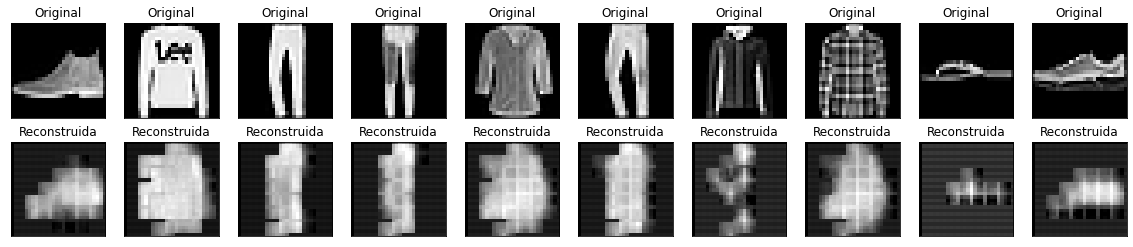

In [41]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(Xtest[i].reshape(28,28))
  plt.title("Original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.title("Reconstruida")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [104]:
class AutoEncoder_conv_2(tf.keras.Model):
    """
    AutoEncoder con capas densas.
    """
    def __init__(self, input_shape, latent_dim):
        """
        Parameters
        ----------
        input_shape: int
            Ancho/largo de las imágenes.
        latent_dim: int
            Dimensión del espacio latente.
        """
        super(AutoEncoder_conv_2, self).__init__() #Hereda todos los métodos de tf.keras.Model
        
        #Creamos el modelo secuencial para el encoder
        self.encoder = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3,3), activation = "relu", #Imagen28*28
                                   input_shape=(input_shape,input_shape,1), padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), #Reducimos la imagen a la mitad 14*14
            tf.keras.layers.Conv2D(16, (3,3), activation = "relu", padding='same'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),#Reducimos la imagen a la mitad 7*7
            tf.keras.layers.Conv2D(8, (3,3), activation = "relu", padding='same')
        ])
        
        self.decoder = tf.keras.models.Sequential([
            tf.keras.layers.Conv2DTranspose(16,(3,3), activation = "relu", 
                                            padding='same', strides = (2,2)),
            tf.keras.layers.Conv2DTranspose(32,(3,3), activation = "relu", 
                                            padding='same', strides = (2,2)),
            tf.keras.layers.Conv2DTranspose(1,(3,3), activation = "relu", 
                                            padding='same', strides = (1,1))
        ])
    
    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded  